In [1]:
# @title Dependencias

!pip install lightgbm vaderSentiment scikit-learn category_encoders scipy

import pandas as pd
import numpy as np
from scipy.sparse import hstack
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
)

import category_encoders as ce

# Colores para los gráficos
NOT_A_DISASTER_COLOR = '#808080'
DISASTER_COLOR = '#C0392B'


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 4.4 MB/s eta 0:00:00


In [2]:
# @title Carga de archivos
URL_BASE = '/kaggle/input/nlp-getting-started/'

train_file             = URL_BASE + 'train.csv'
test_file              = URL_BASE + 'test.csv'
sample_submission_file = URL_BASE + 'sample_submission.csv'

# Carga de datasets
df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

In [3]:
# @title Seteo de semilla para reproducibilidad:

SEMILLA = 111014
np.random.seed(SEMILLA)

In [4]:
# @title Limpieza + Features

def get_avg_word_length(text):
    words = text.split()
    if len(words) == 0:
        return 0
    total_chars_in_words = sum(len(word) for word in words)
    return total_chars_in_words / len(words)

# Relleno de nulos
df_train['text'] = df_train['text'].fillna('')
df_test['text']  = df_test['text'].fillna('')

df_train['keyword'] = df_train['keyword'].fillna('no_keyword')
df_train['location'] = df_train['location'].fillna('no_location')

df_test['keyword'] = df_test['keyword'].fillna('no_keyword')
df_test['location'] = df_test['location'].fillna('no_location')

def add_features(df):
    df['text_length'] = df['text'].apply(len)
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))
    df['avg_word_length'] = df['text'].apply(get_avg_word_length)
    df['has_url'] = df['text'].str.contains('http').astype(int)
    df['has_hashtag'] = df['text'].str.contains('#').astype(int)
    df['keyword_is_null'] = df['keyword'].eq('no_keyword').astype(int)
    return df

df_train = add_features(df_train)
df_test  = add_features(df_test)

# Definimos las listas de features que vamos a usar luego
quantile_features = ['text_length', 'word_count', 'avg_word_length']
binary_features   = ['has_url', 'has_hashtag', 'keyword_is_null']

numeric_features = quantile_features + binary_features     # numéricas
cat_features     = ['keyword', 'location']                 # categóricas
meta_features    = numeric_features + cat_features         # todas las no-texto


In [5]:
# @title Modelo (Regresión Logística Baseline)

# 1) Armamos X, y a partir de df_train
X = df_train.copy()
y = X['target'].values
X.drop(columns=['target'], inplace=True)

# 2) Split train / validación (estratificado y reproducible)
X_tr, X_val, y_tr, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=SEMILLA,
    stratify=y
)

# 3) Target Encoding sobre las columnas categóricas (keyword, location)
encoder = ce.TargetEncoder(cols=cat_features)

X_tr_enc = X_tr.copy()
X_val_enc = X_val.copy()

X_tr_enc[cat_features] = encoder.fit_transform(X_tr_enc[cat_features], y_tr)
X_val_enc[cat_features] = encoder.transform(X_val_enc[cat_features])

# 4) TF-IDF para el texto (embedding simple)
tfidf = TfidfVectorizer(max_features=3000, lowercase=False, stop_words='english')

X_tr_text = tfidf.fit_transform(X_tr_enc['text'])
X_val_text = tfidf.transform(X_val_enc['text'])

# 5) Matrices finales: texto + features numéricas + categóricas encodeadas
X_tr_meta = X_tr_enc[meta_features].values
X_val_meta = X_val_enc[meta_features].values

X_tr_all = hstack([X_tr_text, X_tr_meta])
X_val_all = hstack([X_val_text, X_val_meta])

# 6) Regresión logística con búsqueda de hiperparámetros
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs'],
}

logreg = LogisticRegression(max_iter=1000, random_state=SEMILLA)

grid = GridSearchCV(
    logreg,
    param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_tr_all, y_tr)

best_model = grid.best_estimator_
y_val_pred = best_model.predict(X_val_all)

print("Mejores hiperparámetros:", grid.best_params_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Mejores hiperparámetros: {'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs'}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1 de validación: 0.7342767295597484
Accuracy: 0.778069599474721
Precision_0: 0.7933701657458564
Precision_1: 0.7556634304207119
Recall_0: 0.8262370540851554
Recall_1: 0.7140672782874617

Matriz de Confusión: 
[[718 151]
 [187 467]]


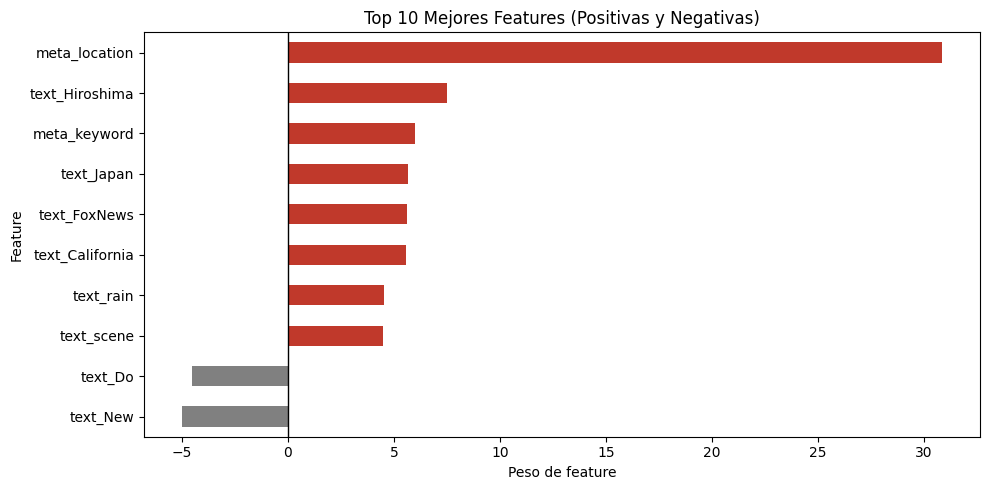

In [6]:
# @title Metricas para ver si el modelo fue bueno:

# F1 Nos lo piden
f1_val = f1_score(y_val, y_val_pred)
print("F1 de validación:", f1_val)

# Accuracy
accuracy = accuracy_score(y_val, y_val_pred)

# Precision para cada clase
precision_1 = precision_score(y_val, y_val_pred, pos_label=1)
precision_0 = precision_score(y_val, y_val_pred, pos_label=0)

# Recall para cada clase
recall_1 = recall_score(y_val, y_val_pred, pos_label=1)
recall_0 = recall_score(y_val, y_val_pred, pos_label=0)

cm = confusion_matrix(y_val, y_val_pred)

print("Accuracy:", accuracy)
print("Precision_0:", precision_0)
print("Precision_1:", precision_1)
print("Recall_0:", recall_0)
print("Recall_1:", recall_1)
print("")
print("Matriz de Confusión: ")
print(cm)

# -------- Feature Importance --------

# Nombres de features: primero TF-IDF, luego las meta_features
tfidf_features_prefixed = [f"text_{f}" for f in tfidf.get_feature_names_out()]
meta_features_prefixed = [f"meta_{f}" for f in meta_features]

feature_names = np.concatenate([tfidf_features_prefixed, meta_features_prefixed])

coefficients = best_model.coef_[0]

importance_df = pd.Series(coefficients, index=feature_names)
abs_importance = importance_df.abs()

top_10_features_names = abs_importance.nlargest(10).index
plot_df = importance_df[top_10_features_names].sort_values()

plt.figure(figsize=(10, 5))
ax = plot_df.plot(
    kind='barh',
    color=[DISASTER_COLOR if x > 0 else NOT_A_DISASTER_COLOR for x in plot_df.values]
)
ax.axvline(x=0, color='black', linewidth=1)

plt.title('Top 10 Mejores Features (Positivas y Negativas)')
plt.xlabel('Peso de feature')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [7]:
# @title Predicción y Submission para Kaggle (Baseline)

# Aplicamos el mismo encoder de target encoding a df_test
df_test_enc = df_test.copy()
df_test_enc[cat_features] = encoder.transform(df_test_enc[cat_features])

# Embedding del texto de test con el mismo TF-IDF
X_test_text = tfidf.transform(df_test_enc['text'])
X_test_meta = df_test_enc[meta_features].values

X_test_all = hstack([X_test_text, X_test_meta])

# Predicción final para Kaggle
y_test_pred = best_model.predict(X_test_all)

submission = pd.read_csv(sample_submission_file)
submission['target'] = y_test_pred
submission.to_csv(URL_BASE + 'submission_baseline.csv', index=False)

print("Archivo de submission guardado en:", URL_BASE + 'submission_baseline.csv')


Archivo de submission guardado en: /content/drive/MyDrive/MATERIAS/Ciencia de Datos/nlp-getting-started/submission_baseline.csv


In [8]:
## @title Metricas para ver si el modelo fue bueno:
#
## F1 Nos lo piden
#f1_val = f1_score(y_val, y_val_pred)
#print("F1 de validación:", f1_val)
#
## La accuracy es una metrica que se mide en:
##Cantidad de aciertos / Totales
## Usando 0.5 de umbral
#accuracy = accuracy_score(y_val, y_val_pred)
#
## La precision es una metrica que se mide en:
## Cuantos Desastres predichos son de verdad desastres
## (Cantidad de 1s correctos / Cantidad de 1s) o lo mismo pero con los 0s
#precision_1 = precision_score(y_val, y_val_pred, pos_label=1)
#precision_0 = precision_score(y_val, y_val_pred, pos_label=0)
#
## Es el Analogo de la Precision:
## Recall: Cuantos de los que son de una clase predije como de esa clase?
## 1s Recuperados / Cantidad total de 1s
#
#recall_1 = recall_score(y_val, y_val_pred, pos_label=1)
#recall_0 = recall_score(y_val, y_val_pred, pos_label=0)
#
#cm = confusion_matrix(y_val, y_val_pred)
#
#print("Accuracy:", accuracy)
#print("Precision_0:", precision_0)
#print("Precision_1:", precision_1)
#print("Recall_0:", recall_0)
#print("Recall_1:", recall_1)
#print("")
#
#print("Matriz de Confusion: ")
#print(cm)
#

In [9]:
# NOT_A_DISASTER_COLOR = '#808080'
# DISASTER_COLOR = '#C0392B'
#
# tfidf_features_prefixed = [f"text_{f}" for f in tfidf.get_feature_names_out()]
# meta_features_prefixed = [f"meta_{f}" for f in quantile_features + categorical_features]
#
# feature_names = np.concatenate([tfidf_features_prefixed, meta_features_prefixed])
#
# coefficients = best_model.coef_[0]
#
# importance_df = pd.Series(coefficients, index=feature_names)
# abs_importance = importance_df.abs()
#
# top_10_features_names = abs_importance.nlargest(10).index
# plot_df = importance_df[top_10_features_names].sort_values()
#
# plt.figure(figsize=(10, 5))
# ax = plot_df.plot(
#     kind='barh',
#     color=[DISASTER_COLOR if x > 0 else NOT_A_DISASTER_COLOR for x in plot_df.values]
# )
# ax.axvline(x=0, color='black', linewidth=1)
#
# plt.title('Top 10 Mejores Features (Positivas y Negativas)')
# plt.xlabel('Peso de feature')
# plt.ylabel('Feature')
# plt.tight_layout()
# plt.show()
#

In [10]:
y_test_pred = best_model.predict(X_test_all)

submission = pd.read_csv(sample_submission_file)
submission['target'] = y_test_pred

submission.to_csv( URL_BASE + '/submission_baseline.csv', index=False)